In [1]:
import pandas as pd
import numpy as np

### <b>Dataset</b>

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = pd.read_csv(data)
df

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


In [3]:
features = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 
            'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

### <b>Data preparation</b>

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
df = df[features]
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df = df.fillna(0)

In [7]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

In [8]:
mean_price = df.msrp.mean()
df['above_average'] = (df.msrp > mean_price).astype(int)
del df['msrp']

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25)

In [10]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
y_train = df_train['above_average']
y_val = df_val['above_average']
y_test = df_test['above_average']

In [12]:
del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### <b>Question 1: ROC AUC feature importance</b>

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
for feature in numerical:
    if roc_auc_score(y_train, df_train[feature]) < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    else:
        score = roc_auc_score(y_train, df_train[feature])
    
    print(feature, score)

year 0.6965462258910957
engine_hp 0.9161599587092121
engine_cylinders 0.7635283892123628
highway_mpg 0.6252313329566568
city_mpg 0.6680658370202959


### <b>Question 2: Training the model</b>

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
above_average_pred = (y_pred >= 0.5)

score = roc_auc_score(y_val, above_average_pred)
round(score, 3)

0.908

### <b>Question 3: Precision and Recall</b>

In [17]:
import matplotlib.pyplot as plt

In [18]:
precision = []
recall = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))

C:\Users\CrackedStone\AppData\Local\Temp\ipykernel_14192\1538181244.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision.append(tp / (tp + fp))


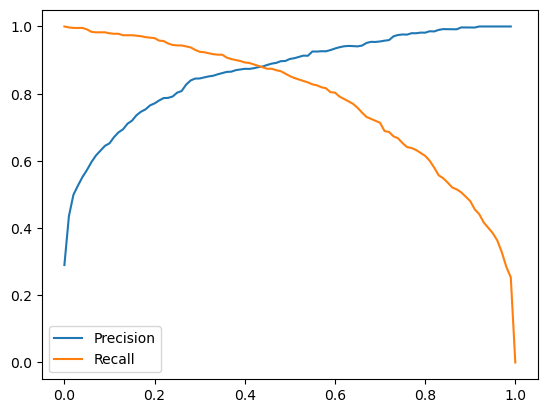

In [19]:
plt.plot(thresholds, precision, label = 'Precision')
plt.plot(thresholds, recall, label = 'Recall')
plt.legend()

### <b>Question 4: F1 score</b>

In [20]:
f1_max = -1
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1 = 2 * p * r / (p + r)
    
    if f1 > f1_max:
        f1_max = f1
        res = t
    
print(res)

0.35000000000000003


C:\Users\CrackedStone\AppData\Local\Temp\ipykernel_14192\1896253576.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


### <b>Question 5: 5-Fold CV</b>

In [21]:
from sklearn.model_selection import KFold

In [22]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [23]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['above_average'].values
    y_val = df_val['above_average'].values
    
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'{round(np.mean(scores), 3)} +- {round(np.std(scores), 3)}')

0.981 +- 0.003


### <b>Question 6: Hyperparemeter Tuning</b>

In [25]:
for C in [0.01, 0.1, 0.5, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['above_average'].values
        y_val = df_val['above_average'].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C} {round(np.mean(scores), 3)} +- {round(np.std(scores), 3)}')

C=0.01 0.952 +- 0.003
C=0.1 0.972 +- 0.002
C=0.5 0.978 +- 0.001
C=10 0.981 +- 0.003
